In [1]:
# Environment setup: conda env create -f requirements.yaml
# Activate environment: conda activate islets-omics

%load_ext autoreload
%autoreload 2

import sys

import pandas as pd
import numpy as np

import scipy.stats as stats
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score

import matplotlib.pyplot as plt

# get data
data = pd.read_pickle("./data/datasets/islets_rna_prot_dataset.pkl")
sample_metadata = pd.read_pickle("./data/datasets/islets_rna_prot_sample_metadata.pkl")
feature_metadata = pd.read_pickle("./data/datasets/islets_rna_prot_feature_metadata.pkl")

sys.path.append("src.py")
from src import Utils


### [F05] Correlation coefficient boxplots:

Boxplots: three boxplots with two groups each and six datapoints per group + ttest. Datapoints are the correlation coefficients from the previous figure. Leave significance coloring out for now. 

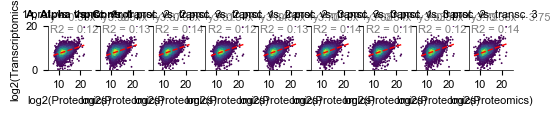

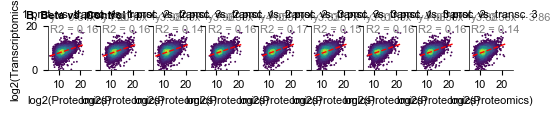

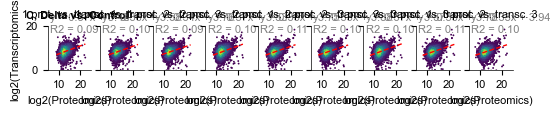

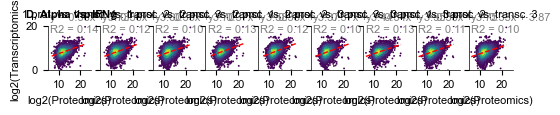

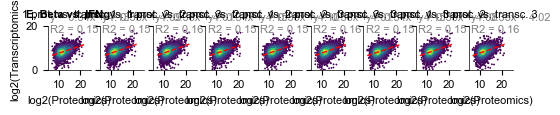

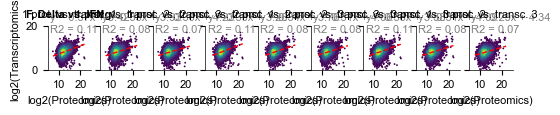

In [2]:
def fig_02_replicate_datasets(
        data : pd.DataFrame = None,
        sample_metadata: pd.DataFrame = None,
):

    # set pairs to compare in faceted plot
    replicate_pairs = [
        ('1', '1'), ('1', '2'), ('1', '3'), 
        ('2', '1'), ('2', '2'), ('2', '3'),
        ('3', '1'), ('3', '2'), ('3', '3'),
        ]
    
    # str pairs as list of tuples
    str_pairs = [
        ('alpha_control_proteomics', 'alpha_control_transcriptomics'),
        ('beta_control_proteomics', 'beta_control_transcriptomics'),
        ('delta_control_proteomics', 'delta_control_transcriptomics'),
        ('alpha_ifng_proteomics', 'alpha_ifng_transcriptomics'),
        ('beta_ifng_proteomics', 'beta_ifng_transcriptomics'),
        ('delta_ifng_proteomics', 'delta_ifng_transcriptomics')]

    # compute pairwise correlations. We need one dataframe per
    # sample_treat_readout pair, where readout vanishes after correlation
    sample_treatment_dataframes = {}
    for str_p, str_t in str_pairs:

        # parse str_pairs
        sample_treatment_p = str_p.split("_")[0] + "_" + str_p.split("_")[1]
        sample_treatment_t = str_t.split("_")[0] + "_" + str_t.split("_")[1]
        if sample_treatment_p != sample_treatment_t:
            raise ValueError("Error in sample_treatment parsing")

        sample_treatment_temp_dfs = []
        for r_p, r_t in replicate_pairs:
            
            # get corresponding row indices
            idx_p = sample_metadata[(sample_metadata['rep'] == r_p) & (sample_metadata['sample_treat_readout'] == str_p)].index
            idx_t = sample_metadata[(sample_metadata['rep'] == r_t) & (sample_metadata['sample_treat_readout'] == str_t)].index
            if len(idx_p) != 1 or len(idx_t) != 1:
                raise ValueError("Error in replicate indexing")
            
            # get ids and value vectors
            ids = data.columns.values
            p_vec = data.loc[idx_p].values.flatten()
            t_vec = data.loc[idx_t].values.flatten()

            # replicate pair
            replicate_pair = r_p + "p_t" + r_t

            # assemble output
            sample_treatment_dataframe = pd.DataFrame({
                'protein_group' : ids,
                'transcriptome_value' : t_vec,
                'proteome_value' : p_vec,
                'replicate_pair' : replicate_pair,
                'sample_treatment' : sample_treatment_p,
            })

            # store in dictionary
            sample_treatment_temp_dfs.append(sample_treatment_dataframe)

        # concatenate dataframes for curent sample_treatment pair
        concatenated_st_df = pd.concat(sample_treatment_temp_dfs)

        # store in dictionary
        sample_treatment_dataframes[sample_treatment_p] = concatenated_st_df

    # return correlation dataframes in dictionary
    return sample_treatment_dataframes

# produce scatterplots and log regression coefficients
def fig_02_scatterplots(
        sample_treatment_dataframes: dict = None,
):

    # iterate over sample_treatment pairs
    plot_numbers = ['A', 'B', 'C', 'D', 'E', 'F']
    regression_coefficients = {}
    for plot_number, (sample_treatment, df) in zip(plot_numbers, sample_treatment_dataframes.items()):
        
        # get data
        plot_df = df[['proteome_value', 'transcriptome_value']]
        plot_md = df[['replicate_pair', 'sample_treatment']]

        # produce scatterplot
        label_parse_dict = {
            'proteome_value' : 'log2(Proteomics)',
            'transcriptome_value' : 'log2(Transcriptomics)',
        }

        def label_parse_regex(l):
            l = l.replace('_', ' vs. ')
            # l = l.replace('proteomics', 'Proteomics')
            # l = l.replace('transcriptomics', 'Transcriptomics')
            l = l.replace('alpha', 'Alpha')
            l = l.replace('beta', 'Beta')
            l = l.replace('delta', 'Delta')
            l = l.replace('control', 'Control')
            l = l.replace('ifng', 'IFNg')
            l = l.replace('p ', ' prot. ')
            l = l.replace(' t', ' transc. ')

            return l

        f, a = Utils.scatter(
            data = plot_df,
            metadata = plot_md,
            x_col = 'proteome_value',
            y_col = 'transcriptome_value',
            color_column = 'replicate_pair',
            segments = 'facets',
            title = '',
            ylabel = None,
            xlabel = None,
            facet_titles = True,
            density = True,
            linear_regression = True,
            show_equation = True,
            figsize_x = 6, 
            figsize_y = 1,
            xlim = (5, 25),
            ylim = (0, 20),
            enumerate_plot = f'{plot_number}, {sample_treatment}',
            label_lookup_dict = label_parse_dict,
            label_general_regex = label_parse_regex,
            scatter_kwargs = {'s': 7},
            aspect_equal = True,
        )

        # iterate over replicate pairs and calculate linear regression coefficient
        # also sanity check for r2 from plotting class regression
        replicate_r2 = {}
        replicate_pearsonr = {}
        replicate_k = {}
        replicate_d = {}
        for replicate_pair in df['replicate_pair'].unique():
            # get data
            replicate_df = df[df['replicate_pair'] == replicate_pair]
            x = replicate_df['proteome_value'].values
            y = replicate_df['transcriptome_value'].values

            # remove nans
            nan_mask = np.isnan(x) | np.isnan(y)
            x = x[~nan_mask].reshape(-1, 1)
            y = y[~nan_mask].reshape(-1, 1)

            # fit linear regression
            reg = LinearRegression().fit(x, y)
            y_pred = reg.predict(x)

            # calculate r2
            r2 = r2_score(y, y_pred)
            replicate_r2[replicate_pair] = r2

            # calculate pearsonr
            pearsonr = stats.pearsonr(x.flatten(), y.flatten())
            replicate_pearsonr[replicate_pair] = pearsonr.statistic

            # store coefficients
            replicate_k[replicate_pair] = reg.coef_[0][0]
            replicate_d[replicate_pair] = reg.intercept_[0]

        # store replicate r2
        regression_coefficients[sample_treatment] = {
            'r2' : replicate_r2,
            'pearsonr' : replicate_pearsonr,
            'k' : replicate_k,
            'd' : replicate_d,
        }

    # return regression coefficients
    return regression_coefficients

f2ds = fig_02_replicate_datasets(data = data, sample_metadata=sample_metadata)
f2ds_coeff = fig_02_scatterplots(f2ds)

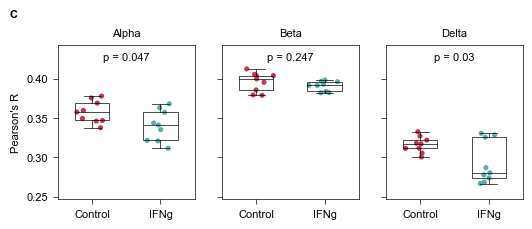

In [3]:
def fig_05_correlation_boxplots(f51ds_coefficients, treatments = ['control', 'ifng']):

    # cast corresponding coefficients to dataframe
    cts = []
    cs = []
    ts = []
    rrs = []
    Rs = []
    ks = []
    ds = []
    for ct, values in f51ds_coefficients.items():
        for pearsonr, rvals in values['pearsonr'].items():
            cts.append(ct)
            cs.append(ct.split("_")[0])
            ts.append(ct.split("_")[1])
            rrs.append(pearsonr)
            Rs.append(rvals)
            ks.append(values['k'][pearsonr])
            ds.append(values['d'][pearsonr])

    # make dataframe
    df = pd.DataFrame({
        'sample_treatment' : cts,
        'cell' : cs,
        'treatment' : ts,
        'replicate_pair' : rrs,
        'R' : Rs,
        'k' : ks,
        'd' : ds,
    })

    label_parse_dict = {
        'R' : "Pearson's R",
        'control' : 'Control',
        'ifng' : 'IFNg',
        'cell: alpha' : 'Alpha',
        'cell: beta' : 'Beta',
        'cell: delta' : 'Delta',
    }

    f, a = Utils.boxplot(
        data = df,
        value_col = 'R',
        color_col = 'treatment',
        grouping_col = 'treatment',
        subplot_col = 'cell',
        normal_jitter = 0.1,
        xtick_kwargs = dict(rotation=0, ha='center'), 
        ttest_pvalue_xy = (0.5, 0.9),
        ylim_padding = (0.02, 0.03),
        scatter_kwargs = {'s': 7},
        show_facet_xlabel = False,
        enumerate_plot = 'C',
        enumeration_xy = (-0.35, 1.2),
        label_lookup_dict = label_parse_dict,
    )

    # save plot
    Utils.save_figure(
        fig = f, 
        filename = f"figure_05_correlation_boxplots.svg",
        output_dir = "./assets/20250423_revision_figures/",
        dpi = 300,
        paper_width = "1.5",
        paper_height = '0.5'
    )

fig_05_correlation_boxplots(f2ds_coeff)